In [2]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_tasks_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names
from samplers import get_data_sampler
from tasks import get_task_sampler
from train import config_load_special
import numpy as np
from utils.manual_solvers import w_sig_NGgenerator, w_sig_NGposterior, w_sig_ridge
import copy



%matplotlib inline
%load_ext autoreload
%autoreload 2


root_path =

all_experiments = []

for pool_size in [1024, 4096, 16384]:

    all_experiments.append("official_1_UQ_poolSize_" + str(pool_size))

## load everything

model_dic = {}
config_dic = {}
ys_dic = {}
mus_dic = {}
sigs_dic = {}
exempt_dic = {}
predmu_dic = {}
predsigma_dic = {}

bayes_mus_dic = {}
bayes_sigs_dic = {}
ridge_mus_dic = {}
ridge_sigs_dic = {}
OLS_mus_dic = {}
OLS_sigs_dic = {}

FalseP_bayes_mus_dic = {}
FalseP_bayes_sigs_dic = {}


for experiment in all_experiments:

    model_path = os.path.join(root_path, experiment)

    model, _ = get_model_from_run(model_path)

    config = config_load_special(model_path)

    model_dic[experiment] = model

    config_dic[experiment] = config

# generate test data
sample_key = list(config_dic.keys())[0]

n_dims = config_dic[sample_key].model.n_dims
batch_size = config_dic[sample_key].training.batch_size

data_sampler = get_data_sampler(config_dic[sample_key].training.data, n_dims)
xs = data_sampler.sample_xs(b_size=batch_size, n_points=config_dic[sample_key].training.curriculum.points.end)


groups = {
            "low_sig": (80, 20),
            "original": (20, 20),
            "large_sig": (100, 400),
            "huge_sig": (100, 1600)
        }

for experiment in all_experiments:

    for sig_config in list(groups.keys()):


        ## reset w and sigma of task samplers

        mu0 = np.ones(n_dims)

        ## gamma(a, b), mean = a/b, variance = a/b^2
        ## when training, we let a/b=1 and b relatively large

        a0, b0 = groups[sig_config]

        new_ws, new_sigs = w_sig_NGgenerator(a0, b0, mu0, n_dims, batch_size)

        new_exp = experiment + "_" + sig_config

        config_dic[new_exp] = copy.deepcopy(config_dic[experiment])

        config_dic[new_exp].training.task_kwargs["pool_dict"]["w"] = torch.Tensor(np.expand_dims(new_ws, axis=-1))
        config_dic[new_exp].training.task_kwargs["pool_dict"]["sigma"] = torch.Tensor(new_sigs)
        config_dic[new_exp].training.task_kwargs["pool_dict"]["exempt"] = np.zeros(batch_size)

        task_sampler = get_task_sampler(
            config_dic[new_exp].training.task,
            n_dims,
            batch_size,
            **config_dic[new_exp].training.task_kwargs
        )

        task = task_sampler()

        mus, ys, sigma, exemps = task.eval_with_mu_sigma_exempt(xs)

        ys_dic[new_exp] = ys
        mus_dic[new_exp] = mus
        exempt_dic[new_exp]= exemps
        sigs_dic[new_exp] = sigma


        with torch.no_grad():
            pred = model_dic[experiment](xs, ys)

        predmu_dic[new_exp] = pred[:, :, 0]
        predsigma_dic[new_exp] = pred[:, :, 1]

        posterior_mu = np.zeros(predmu_dic[new_exp].shape)
        posterior_sigma = np.zeros(predmu_dic[new_exp].shape)
        falseP_posterior_mu = np.zeros(predmu_dic[new_exp].shape)
        falseP_posterior_sigma = np.zeros(predmu_dic[new_exp].shape)

        ridge_mu = np.zeros(predmu_dic[new_exp].shape)
        ridge_sigma = np.zeros(predmu_dic[new_exp].shape)
        OLS_mu = np.zeros(predmu_dic[new_exp].shape)
        OLS_sigma = np.zeros(predmu_dic[new_exp].shape)


        for selected_index in range(len(predmu_dic[new_exp])):

            # estimated_ws, estimated_sigs = w_sig_NGposterior(xs.numpy()[selected_index], ys.numpy()[selected_index], a0, b0 \
            #                                                 , mu0, MAP_sig=False, bias_adjust=True, pred_Ys= pred[selected_index, :, 0].cpu().numpy())

            estimated_ws, estimated_sigs = w_sig_NGposterior(xs.numpy()[selected_index], ys.numpy()[selected_index], a0, b0 \
                                                            , mu0, MAP_sig=False, bias_adjust=False)


            real_estimated_ws = np.zeros(estimated_ws.shape)
            real_estimated_sigs = np.zeros(estimated_sigs.shape)

            real_estimated_ws[0] = mu0
            # real_estimated_sigs[0] = np.sqrt(b0/(a0-1)* (1+ np.linalg.norm(xs.numpy()[selected_index, 0])**2) + (np.dot(xs.numpy()[selected_index, 0], mu0) - pred[selected_index, 0, 0].cpu().numpy())**2)
            real_estimated_sigs[0] = np.sqrt(b0/(a0-1)* (1+ np.linalg.norm(xs.numpy()[selected_index, 0])**2))




            # print("adjust_amount: ", np.sqrt(b0/(a0-1)* (1+ np.linalg.norm(xs.numpy()[selected_index, 0])**2) + (np.dot(xs.numpy()[selected_index, 0], mu0) - pred[selected_index, 0, 0].cpu().numpy())**2) \
            #       - np.sqrt(b0/(a0-1)* (1+ np.linalg.norm(xs.numpy()[selected_index, 0])**2)))

            real_estimated_ws[1:] = estimated_ws[:-1]
            real_estimated_sigs[1:] = estimated_sigs[:-1]

            posterior_mu[selected_index, :] = (np.expand_dims(xs.numpy()[selected_index, :], axis=1) @ np.expand_dims(real_estimated_ws, axis=-1))[:, 0, 0]
            posterior_sigma[selected_index, :] = real_estimated_sigs





            a_f, b_f = groups["original"]
            false_estimated_ws, false_estimated_sigs = w_sig_NGposterior(xs.numpy()[selected_index], ys.numpy()[selected_index], a_f, b_f \
                                                            , mu0, MAP_sig=False, bias_adjust=False)
            false_real_estimated_ws = np.zeros(false_estimated_ws.shape)
            false_real_estimated_sigs = np.zeros(false_estimated_sigs.shape)

            false_real_estimated_ws[0] = mu0
            # real_estimated_sigs[0] = np.sqrt(b0/(a0-1)* (1+ np.linalg.norm(xs.numpy()[selected_index, 0])**2) + (np.dot(xs.numpy()[selected_index, 0], mu0) - pred[selected_index, 0, 0].cpu().numpy())**2)
            false_real_estimated_sigs[0] = np.sqrt(b_f/(a_f-1)* (1+ np.linalg.norm(xs.numpy()[selected_index, 0])**2))

            false_real_estimated_ws[1:] = false_estimated_ws[:-1]
            false_real_estimated_sigs[1:] = false_estimated_sigs[:-1]

            falseP_posterior_mu[selected_index, :] = (np.expand_dims(xs.numpy()[selected_index, :], axis=1) @ np.expand_dims(false_real_estimated_ws, axis=-1))[:, 0, 0]
            falseP_posterior_sigma[selected_index, :] = false_real_estimated_sigs




            ridge_ws, ridge_sigs = w_sig_ridge(xs.numpy()[selected_index], ys.numpy()[selected_index], alpha=0.5)
            
            ridge_mu[selected_index, 1:] = (np.expand_dims(xs.numpy()[selected_index, 1:], axis=1) @ np.expand_dims(ridge_ws[:-1], axis=-1))[:, 0, 0]
            ridge_sigma[selected_index, 1:] = ridge_sigs[:-1]


            OLS_ws, OLS_sigs = w_sig_ridge(xs.numpy()[selected_index], ys.numpy()[selected_index], alpha=0.001)
            
            OLS_mu[selected_index, 1:] = (np.expand_dims(xs.numpy()[selected_index, 1:], axis=1) @ np.expand_dims(OLS_ws[:-1], axis=-1))[:, 0, 0]
            OLS_sigma[selected_index, 1:] = OLS_sigs[:-1]



        bayes_mus_dic[new_exp] = posterior_mu
        bayes_sigs_dic[new_exp] = posterior_sigma
        FalseP_bayes_mus_dic[new_exp] = falseP_posterior_mu
        FalseP_bayes_sigs_dic[new_exp] = falseP_posterior_sigma


        ridge_mus_dic[new_exp] = ridge_mu
        ridge_sigs_dic[new_exp] = ridge_sigma
        OLS_mus_dic[new_exp] = OLS_mu
        OLS_sigs_dic[new_exp] = OLS_sigma


# 8min

## estimation of sigma in "large_sig" regime

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


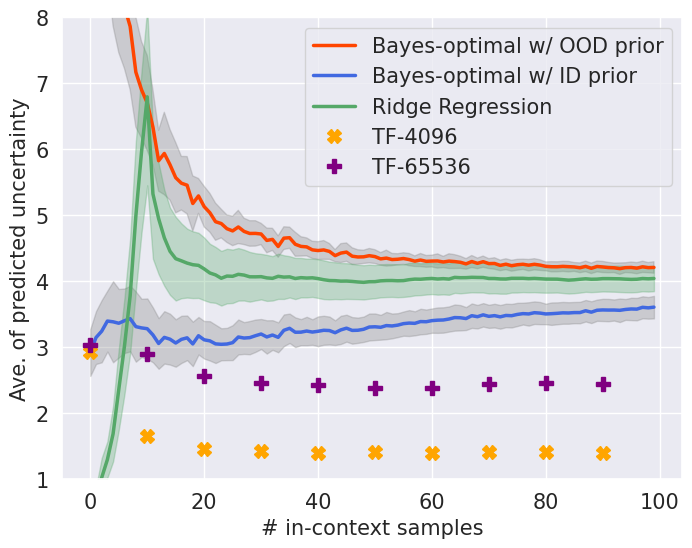

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter


std_Bayes = {}
std_FalseP_Bayes = {}
std_Ridge = {}
std_OLS = {}
std_model = {}

std_Bayes_fluc = {}
std_FalseP_Bayes_fluc = {}
std_Ridge_fluc = {}
std_OLS_fluc = {}
std_model_fluc = {}

def softplus(arr):
    return np.log(1+np.exp(arr))


for sig_config in list(groups.keys()):
    
    sample_experiment = "official_1_UQ_poolSize_16384_" + sig_config

    bayes_mus = bayes_mus_dic[sample_experiment]
    FalseP_bayes_mus = FalseP_bayes_mus_dic[sample_experiment]

    ridge_mus = ridge_mus_dic[sample_experiment]
    OLS_mus = OLS_mus_dic[sample_experiment]

    std_Bayes[sig_config] = bayes_sigs_dic[sample_experiment].mean(axis=0)
    std_FalseP_Bayes[sig_config] = FalseP_bayes_sigs_dic[sample_experiment].mean(axis=0)

    std_Ridge[sig_config] = ridge_sigs_dic[sample_experiment].mean(axis=0)
    std_OLS[sig_config] = OLS_sigs_dic[sample_experiment].mean(axis=0)

    std_Bayes_fluc[sig_config] = bayes_sigs_dic[sample_experiment].std(axis=0)
    std_FalseP_Bayes_fluc[sig_config] = FalseP_bayes_sigs_dic[sample_experiment].std(axis=0)

    std_Ridge_fluc[sig_config] = ridge_sigs_dic[sample_experiment].std(axis=0)
    std_OLS_fluc[sig_config] = OLS_sigs_dic[sample_experiment].std(axis=0)


for sig_config in list(groups.keys()):
    for pool_size in [1024, 4096, 16384]:

        experiment = "official_1_UQ_poolSize_" + str(pool_size) + "_" + sig_config        

        std_model[sig_config + "_" + str(pool_size)] = softplus(predsigma_dic[experiment].numpy()).mean(axis=0)
        std_model_fluc[sig_config + "_" + str(pool_size)] = softplus(predsigma_dic[experiment].numpy()).std(axis=0)




# Sample data
x_range = 100
x_base = np.arange(0, x_range)
dist_setting = "huge_sig"

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(x_base, savgol_filter(std_Bayes[dist_setting][:x_range], window_length=1, polyorder=0),\
         '-', label='Bayes-optimal w/ OOD prior', color="orangered", linewidth = 2.5)
ax.fill_between(x_base, std_Bayes[dist_setting][:x_range] - std_Bayes_fluc[dist_setting][:x_range]/2, \
                std_Bayes[dist_setting][:x_range] + std_Bayes_fluc[dist_setting][:x_range]/2, \
                    color='grey', alpha=0.3)

ax.plot(x_base, savgol_filter(std_FalseP_Bayes[dist_setting][:x_range], window_length=1, polyorder=0),\
         '-', label='Bayes-optimal w/ ID prior', color="royalblue", linewidth = 2.5)
ax.fill_between(x_base, std_FalseP_Bayes[dist_setting][:x_range] - std_FalseP_Bayes_fluc[dist_setting][:x_range]/2, \
                std_FalseP_Bayes[dist_setting][:x_range] + std_FalseP_Bayes_fluc[dist_setting][:x_range]/2, \
                    color='grey', alpha=0.3)


ax.plot(x_base, savgol_filter(std_Ridge[dist_setting][:x_range], window_length=1, polyorder=0), \
        '-', label='Ridge Regression', color="g", linewidth=2.5)
ax.fill_between(x_base, std_Ridge[dist_setting][:x_range] - std_Ridge_fluc[dist_setting][:x_range]/2, \
                std_Ridge[dist_setting][:x_range] + std_Ridge_fluc[dist_setting][:x_range]/2, \
                    color='g', alpha=0.3)


# ax.plot(x_base, savgol_filter(std_OLS[dist_setting][:x_range], window_length=1, polyorder=0), \
#        '-', label='Linear Regression', color="b", linewidth=2.5)
# ax.fill_between(x_base, std_OLS[dist_setting][:x_range] - std_OLS_fluc[dist_setting][:x_range]/2, \
#                 std_OLS[dist_setting][:x_range] + std_OLS_fluc[dist_setting][:x_range]/2, \
#                     color='b', alpha=0.3)

ax.plot(x_base[::10], savgol_filter(std_model[dist_setting + "_1024"][:x_range][::10], window_length=1, polyorder=0), \
        'X', label='TF-4096', color="orange", ms=10)

ax.plot(x_base[::10], savgol_filter(std_model[dist_setting + "_16384"][:x_range][::10], window_length=1, polyorder=0), \
        'P', label='TF-65536', color="purple", ms=10)

# Labels and title
ax.set_xlabel('# in-context samples', fontsize="15")
ax.set_ylabel('Ave. of predicted uncertainty', fontsize="15")
ax.set_ylim(1, 8) 
# ax.set_title('Uncertainty Prediction by Algorithm, OOD', fontsize="15", fontweight='bold')

# Grid and legend
ax.grid(True)
ax.legend(fontsize="15", loc="upper right")

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

plt.savefig('figures/exp_2_OOD_Std.eps', format='eps')
plt.savefig('figures/exp_2_OOD_Std.png', format='png')

# Show plot
plt.show()


## Larger OOD makes Bayesian inference harder

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


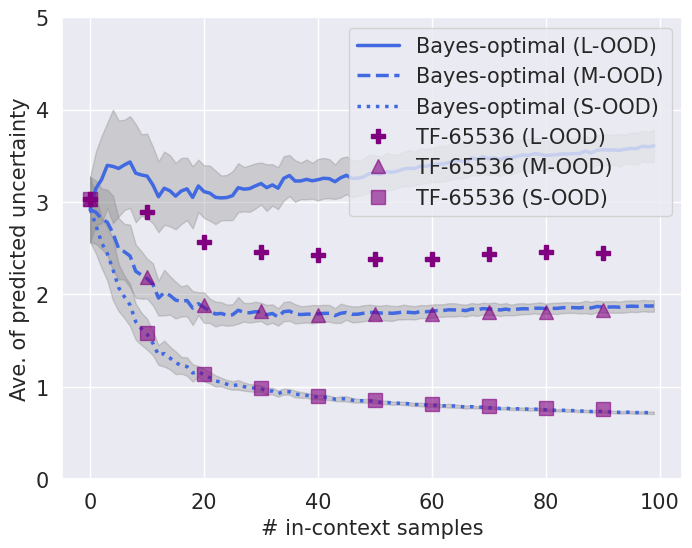

In [35]:
# Sample data
x_range = 100
x_base = np.arange(0, x_range)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))



ax.plot(x_base, savgol_filter(std_FalseP_Bayes["huge_sig"][:x_range], window_length=1, polyorder=0),\
         '-', label='Bayes-optimal (L-OOD)', color="royalblue", linewidth = 2.5)
ax.fill_between(x_base, std_FalseP_Bayes["huge_sig"][:x_range] - std_FalseP_Bayes_fluc["huge_sig"][:x_range]/2, \
                std_FalseP_Bayes["huge_sig"][:x_range] + std_FalseP_Bayes_fluc["huge_sig"][:x_range]/2, \
                    color='grey', alpha=0.3)

ax.plot(x_base, savgol_filter(std_FalseP_Bayes["large_sig"][:x_range], window_length=1, polyorder=0),\
         '--', label='Bayes-optimal (M-OOD)', color="royalblue", linewidth = 2.5)
ax.fill_between(x_base, std_FalseP_Bayes["large_sig"][:x_range] - std_FalseP_Bayes_fluc["large_sig"][:x_range]/2, \
                std_FalseP_Bayes["large_sig"][:x_range] + std_FalseP_Bayes_fluc["large_sig"][:x_range]/2, \
                    color='grey', alpha=0.3)

ax.plot(x_base, savgol_filter(std_FalseP_Bayes["low_sig"][:x_range], window_length=1, polyorder=0),\
         ':', label='Bayes-optimal (S-OOD)', color="royalblue", linewidth = 2.5)
ax.fill_between(x_base, std_FalseP_Bayes["low_sig"][:x_range] - std_FalseP_Bayes_fluc["low_sig"][:x_range]/2, \
                std_FalseP_Bayes["low_sig"][:x_range] + std_FalseP_Bayes_fluc["low_sig"][:x_range]/2, \
                    color='grey', alpha=0.3)


# ax.plot(x_base, savgol_filter(std_OLS[dist_setting][:x_range], window_length=1, polyorder=0), \
#        '-', label='Linear Regression', color="b", linewidth=2.5)
# ax.fill_between(x_base, std_OLS[dist_setting][:x_range] - std_OLS_fluc[dist_setting][:x_range]/2, \
#                 std_OLS[dist_setting][:x_range] + std_OLS_fluc[dist_setting][:x_range]/2, \
#                     color='b', alpha=0.3)

# ax.plot(x_base[::10], savgol_filter(std_model[dist_setting + "_1024"][:x_range][::10], window_length=1, polyorder=0), \
#         'X', label='TF pool-4096', color="orange", ms=10)

ax.plot(x_base[::10], savgol_filter(std_model["huge_sig_16384"][:x_range][::10], window_length=1, polyorder=0), \
        'P', label='TF-65536 (L-OOD)', color="purple", ms=10)

ax.plot(x_base[::10], savgol_filter(std_model["large_sig_16384"][:x_range][::10], window_length=1, polyorder=0), \
        '^', label='TF-65536 (M-OOD)', color="purple", ms=10, alpha=0.6)
ax.plot(x_base[::10], savgol_filter(std_model["low_sig_16384"][:x_range][::10], window_length=1, polyorder=0), \
        's', label='TF-65536 (S-OOD)', color="purple", ms=10, alpha=0.6)

# Labels and title
ax.set_xlabel('# in-context samples', fontsize="15")
ax.set_ylabel('Ave. of predicted uncertainty', fontsize="15")
ax.set_ylim(0, 5) 
# ax.set_title('Performance VS OOD Level', fontsize="15", fontweight='bold')

# Grid and legend
ax.grid(True)
ax.legend(fontsize="15", loc="upper right")

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

plt.savefig('figures/exp_2_OOD_Std_changePrior.eps', format='eps')
plt.savefig('figures/exp_2_OOD_Std_changePrior.png', format='png')

# Show plot
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


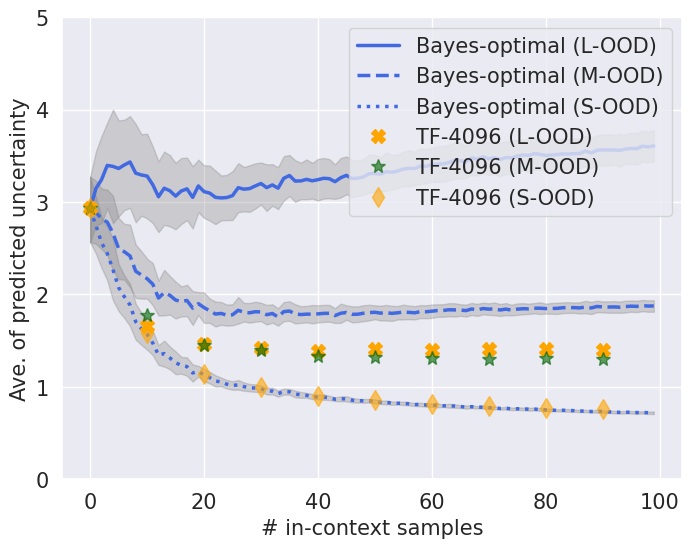

In [36]:
# Sample data
x_range = 100
x_base = np.arange(0, x_range)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))



ax.plot(x_base, savgol_filter(std_FalseP_Bayes["huge_sig"][:x_range], window_length=1, polyorder=0),\
         '-', label='Bayes-optimal (L-OOD)', color="royalblue", linewidth = 2.5)
ax.fill_between(x_base, std_FalseP_Bayes["huge_sig"][:x_range] - std_FalseP_Bayes_fluc["huge_sig"][:x_range]/2, \
                std_FalseP_Bayes["huge_sig"][:x_range] + std_FalseP_Bayes_fluc["huge_sig"][:x_range]/2, \
                    color='grey', alpha=0.3)

ax.plot(x_base, savgol_filter(std_FalseP_Bayes["large_sig"][:x_range], window_length=1, polyorder=0),\
         '--', label='Bayes-optimal (M-OOD)', color="royalblue", linewidth = 2.5)
ax.fill_between(x_base, std_FalseP_Bayes["large_sig"][:x_range] - std_FalseP_Bayes_fluc["large_sig"][:x_range]/2, \
                std_FalseP_Bayes["large_sig"][:x_range] + std_FalseP_Bayes_fluc["large_sig"][:x_range]/2, \
                    color='grey', alpha=0.3)

ax.plot(x_base, savgol_filter(std_FalseP_Bayes["low_sig"][:x_range], window_length=1, polyorder=0),\
         ':', label='Bayes-optimal (S-OOD)', color="royalblue", linewidth = 2.5)
ax.fill_between(x_base, std_FalseP_Bayes["low_sig"][:x_range] - std_FalseP_Bayes_fluc["low_sig"][:x_range]/2, \
                std_FalseP_Bayes["low_sig"][:x_range] + std_FalseP_Bayes_fluc["low_sig"][:x_range]/2, \
                    color='grey', alpha=0.3)


# ax.plot(x_base, savgol_filter(std_OLS[dist_setting][:x_range], window_length=1, polyorder=0), \
#        '-', label='Linear Regression', color="b", linewidth=2.5)
# ax.fill_between(x_base, std_OLS[dist_setting][:x_range] - std_OLS_fluc[dist_setting][:x_range]/2, \
#                 std_OLS[dist_setting][:x_range] + std_OLS_fluc[dist_setting][:x_range]/2, \
#                     color='b', alpha=0.3)

# ax.plot(x_base[::10], savgol_filter(std_model[dist_setting + "_1024"][:x_range][::10], window_length=1, polyorder=0), \
#         'X', label='TF pool-4096', color="orange", ms=10)

ax.plot(x_base[::10], savgol_filter(std_model["huge_sig_1024"][:x_range][::10], window_length=1, polyorder=0), \
        'X', label='TF-4096 (L-OOD)', color="orange", ms=10)

ax.plot(x_base[::10], savgol_filter(std_model["large_sig_1024"][:x_range][::10], window_length=1, polyorder=0), \
        '*', label='TF-4096 (M-OOD)', color="darkgreen", ms=10, alpha=0.6)
ax.plot(x_base[::10], savgol_filter(std_model["low_sig_1024"][:x_range][::10], window_length=1, polyorder=0), \
        'd', label='TF-4096 (S-OOD)', color="orange", ms=10, alpha=0.6)

# Labels and title
ax.set_xlabel('# in-context samples', fontsize="15")
ax.set_ylabel('Ave. of predicted uncertainty', fontsize="15")
ax.set_ylim(0, 5) 
# ax.set_title('Performance VS OOD Level', fontsize="15", fontweight='bold')

# Grid and legend
ax.grid(True)
ax.legend(fontsize="15", loc="upper right")

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

plt.savefig('figures/exp_2_OOD_Std_changePrior_smallpool.eps', format='eps')
plt.savefig('figures/exp_2_OOD_Std_changePrior_smallpool.png', format='png')

# Show plot
plt.show()


## Larger task diversity makes Transformer behave more like Bayesian inference

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


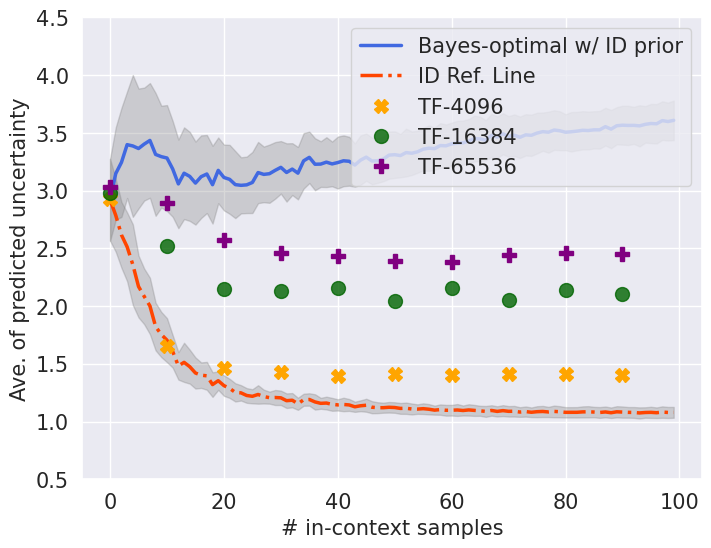

In [37]:
x_range = 100
x_base = np.arange(0, x_range)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))



ax.plot(x_base, savgol_filter(std_FalseP_Bayes["huge_sig"][:x_range], window_length=1, polyorder=0),\
         '-', label='Bayes-optimal w/ ID prior', color="royalblue", linewidth = 2.5)
ax.fill_between(x_base, std_FalseP_Bayes["huge_sig"][:x_range] - std_FalseP_Bayes_fluc["huge_sig"][:x_range]/2, \
                std_FalseP_Bayes["huge_sig"][:x_range] + std_FalseP_Bayes_fluc["huge_sig"][:x_range]/2, \
                    color='grey', alpha=0.3)

ax.plot(x_base, savgol_filter(std_Bayes["original"][:x_range], window_length=1, polyorder=0),\
         '-.', label='ID Ref. Line', color="orangered", linewidth = 2.5)
ax.fill_between(x_base, std_Bayes["original"][:x_range] - std_Bayes_fluc["original"][:x_range]/2, \
                std_Bayes["original"][:x_range] + std_Bayes_fluc["original"][:x_range]/2, \
                    color='grey', alpha=0.3)



ax.plot(x_base[::10], savgol_filter(std_model[dist_setting + "_1024"][:x_range][::10], window_length=1, polyorder=0), \
        'X', label='TF-4096', color="orange", ms=10)

to_plot = savgol_filter(std_model[dist_setting + "_4096"][:x_range][::10], window_length=1, polyorder=0)

ax.plot(x_base[::10], to_plot, \
        'o', label='TF-16384', color="darkgreen", ms=10, alpha=0.8)

ax.plot(x_base[::10], savgol_filter(std_model[dist_setting + "_16384"][:x_range][::10], window_length=1, polyorder=0), \
        'P', label='TF-65536', color="purple", ms=10)






# Labels and title
ax.set_xlabel('# in-context samples', fontsize="15")
ax.set_ylabel('Ave. of predicted uncertainty', fontsize="15")
ax.set_ylim(0.5, 4.5) 
# ax.set_title("Performance VS Training Pool", fontsize="15", fontweight='bold')

# Grid and legend
ax.grid(True)

ax.legend(fontsize="15", loc="upper right")

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)



plt.savefig('figures/exp_2_OOD_Std_ChangePool.eps', format='eps')
plt.savefig('figures/exp_2_OOD_Std_ChangePool.png', format='png')

# Show plot
plt.show()
